# Light curve simulation and fitting

- https://docs.gammapy.org/dev/tutorials/light_curve_simulation.html

- This tutorial explains how to use the temporal models for simulations.

- Frequently, studies of variable sources (eg: decaying GRB light curves, AGN flares, etc) require time variable simulations. For most use cases, it is not necessary to generate an event list sampling all events, but generating fake reduced observations in time bins according to a given temporal model suffices 

**Objective: Simulate and fit a time decaying light curve of a source with CTA using the CTA 1DC response**




## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time
from regions import CircleSkyRegion

import logging

log = logging.getLogger(__name__)

And some gammapy specific imports

In [3]:
from gammapy.data import Observation
from gammapy.irf import load_cta_irfs
from gammapy.datasets import SpectrumDataset, Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpDecayTemporalModel,
    SkyModel,
    LightCurveTemplateTemporalModel,
)
from gammapy.maps import MapAxis
from gammapy.estimators import LightCurveEstimator
from gammapy.makers import SpectrumDatasetMaker
from gammapy.modeling import Fit

## GRB190114C

From paper of MAGIC collaboration (Nature, 575, 455, 2019)

Redshift: z=0.4245

Power law spectrum, with Gamma=5.4, F0=4.1e-10 ph/Tev/cm2/s at E0=0.475 TeV in the 0.3-1 TeV band. 

Power law light curve, with delta=-1.6 [CAVEAT: there is no power law light curve in gammapy!]

T0=14 January 2019, 20:57:03 UTC

MAGIC observations started T+57s and lasted T0+15912 s


## Simulating a light curve

We will simulate 10 datasets using an `PowerLawSpectralModel` and a `ExpDecayTemporalModel`. The important thing to note here is how to attach a different `GTI` to each dataset.

In [4]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

In [5]:
# Reconstructed and true energy axis
center = SkyCoord(0.0, 0.0, unit="deg", frame="galactic")

# [Generate an axis object from a sequence of bin edges: 
# This method should be used to construct an axis where the bin edges 
# should lie at specific values (e.g. a histogram). 
# The number of bins will be one less than the number of edges.
# 0.32-10.0 TeV (true: 0.05-10 TeV)]
energy_axis = MapAxis.from_edges(
    np.logspace(-0.5, 1.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.2, 2.0, 31), unit="TeV", name="energy_true", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=center, radius=on_region_radius)



In [6]:
# Pointing position
pointing = SkyCoord(0.5, 0.5, unit="deg", frame="galactic")

In [7]:
# Define the source model: A combination of spectral and temporal model

# [Start time]
#gti_t0 = Time("2021-01-01")
gti_t0 = Time("2019-01-14")


# [F(E)=F0(E/E0)^Gamma where index= photon index, amplitude = F(E0), reference=E0]
spectral_model = PowerLawSpectralModel(
#    index=2.2, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
    index=5.4, amplitude="4.1e-10 cm-2 s-1 TeV-1", reference="0.475 TeV"
)

# [F(t)=exp((t-t_ref)/t0) where t0=decay time scale, t_ref=start time (gti_t0) in mjd 
# MANCA IL MODELLO TEMPORALE A LEGGE DI POTENZA!! 
# see https://docs.gammapy.org/dev/_modules/gammapy/modeling/models/temporal.html]
#temporal_model = ExpDecayTemporalModel(t0="6 h", t_ref=gti_t0.mjd * u.d)
temporal_model = ExpDecayTemporalModel(t0="6 h", t_ref=gti_t0.mjd * u.d)


# [F(t,E)=F(E)*exp((t-t_ref)/t0)]
model_simu = SkyModel(
    spectral_model=spectral_model,
    temporal_model=temporal_model,
    name="model-simu",
)

In [8]:
# Look at the model
model_simu.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,int64
index,5.400e+00,,nan,nan,False,0.000e+00
amplitude,4.100e-10,cm-2 s-1 TeV-1,nan,nan,False,0.000e+00
reference,4.750e-01,TeV,nan,nan,True,0.000e+00
t0,2.500e-01,d,nan,nan,False,0.000e+00
t_ref,5.850e+04,d,nan,nan,True,0.000e+00


Now, define the start and observation livetime wrt to the reference time, `gti_t0`

In [11]:
#n_obs = 10
#tstart = [1, 2, 3, 5, 8, 9, 22, 24, 25, 26] * u.h
#lvtm = [55, 25, 26, 40, 40, 50, 40, 52, 43, 47] * u.min
n_obs = 6
tstart = [62, 100, 140, 210, 361.5, 800] * u.s
lvtm = [38, 40, 70, 151.5, 38.5, 1654] * u.s

Now perform the simulations

In [12]:
datasets = Datasets()

empty = SpectrumDataset.create(
    e_reco=energy_axis.edges,
    e_true=energy_axis_true.edges,
    region=on_region,
    name="empty",
)

for i in range(n_obs):
    obs = Observation.create(
        pointing=pointing,
        livetime=lvtm[i],
        tstart=tstart[i],
        irfs=irfs,
        reference_time=gti_t0,
    )
    empty_i = empty.copy(name=f"dataset_{i}")
    maker = SpectrumDatasetMaker(selection=["aeff", "background", "edisp"])
    dataset = maker.run(empty_i, obs)
    dataset.models = model_simu
    dataset.fake()
    datasets.append(dataset)


The reduced datasets have been successfully simulated. Let's take a quick look into our datasets.

In [13]:
datasets.info_table()

name,livetime,n_on,background,excess,significance,background_rate,gamma_rate
,s,,,,,1 / s,1 / s
str9,float64,int64,float64,float64,float64,float64,float64
stacked,38.0,45,0.23380101371700857,44.76619898628299,19.59241859949663,0.006152658255710752,1.1780578680600786
dataset_1,40.0,69,0.24610633022843006,68.75389366977156,25.303631183260556,0.006152658255710751,1.7188473417442889
dataset_2,70.0,97,0.4306860778997526,96.56931392210024,29.287816741348422,0.006152658255710751,1.3795616274585747
dataset_3,151.5,203,0.9321277257401789,202.06787227425983,42.20855087628738,0.006152658255710751,1.3337813351436292
dataset_4,38.5,45,0.2368773428448639,44.76312265715514,19.562528770460514,0.00615265825571075,1.162678510575458
dataset_5,1654.0,2146,10.176496754945582,2135.823503245055,136.7334896393857,0.00615265825571075,1.2913080430743984


## 1. Extract the lightcurve

- Using LightCurveEstimator
- Temporal model not accounted

In [14]:
# Define the model:
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_fit = SkyModel(spectral_model=spectral_model, name="model-fit")

In [15]:
# Attach model to each dataset
for dataset in datasets:
    dataset.models = model_fit

In [16]:
%%time
lc_maker_1d = LightCurveEstimator(
    energy_range=[energy_axis.edges[0], energy_axis.edges[-1]],
    source="model-fit",
    reoptimize=False,
)
lc_1d = lc_maker_1d.run(datasets)

CPU times: user 537 ms, sys: 6.56 ms, total: 544 ms
Wall time: 550 ms


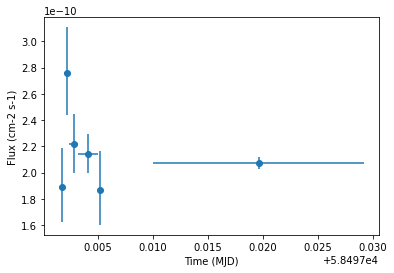

In [17]:
ax = lc_1d.plot(marker="o")

## 2. Joint fitting
- Directly accounting for a temporal model

In [18]:
# Define the model:

spectral_model1 = PowerLawSpectralModel(
    index=2.0, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
temporal_model1 = ExpDecayTemporalModel(t0="10 h", t_ref=gti_t0.mjd * u.d)
model = SkyModel(
    spectral_model=spectral_model1,
    temporal_model=temporal_model1,
    name="model-test",
)

In [19]:
model.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,int64
index,2.000e+00,,nan,nan,False,0.000e+00
amplitude,1.000e-12,cm-2 s-1 TeV-1,nan,nan,False,0.000e+00
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
t0,4.167e-01,d,nan,nan,False,0.000e+00
t_ref,5.850e+04,d,nan,nan,True,0.000e+00


In [20]:
for dataset in datasets:
    dataset.models = model

In [21]:
%%time
# Do a joint fit
fit = Fit(datasets)
result = fit.run()

/Users/giuliastratta/opt/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/giuliastratta/opt/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 6.91 s, sys: 20.7 ms, total: 6.93 s
Wall time: 6.94 s


In [22]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,5.472e+00,,nan,nan,False,8.039e-02
amplitude,6.716e-12,cm-2 s-1 TeV-1,nan,nan,False,5.998e-13
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
t0,3.356e-01,d,nan,nan,False,3.042e-01
t_ref,5.850e+04,d,nan,nan,True,0.000e+00


We see that the fitted parameters match well with the simulated ones!

In [23]:
cnts = []
npreds = []
times = []
lvtm = []
exposure = []
for ds in datasets:
    cnts.append(ds.counts.data.sum())
    npreds.append(ds.npred().data.sum())
    lvtm.append(ds.livetime.value)
    exposure.append(ds.exposure.data.sum())
    times.append((ds.gti.time_start + ds.gti.time_delta/2.0).mjd)
residuals = (np.array(cnts) - np.array(npreds))/np.array(npreds)

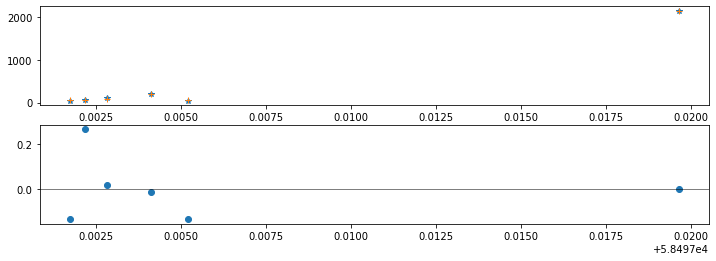

In [24]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(times, cnts, "*")
ax1.plot(times, npreds, "+")

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(times, residuals, "o")
ax2.axhline(0, color="black", lw=0.5)